In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

histopathologic_cancer_detection_path = kagglehub.competition_download('histopathologic-cancer-detection')

print('Data source import complete.')


100%|██████████| 6.31G/6.31G [01:05<00:00, 104MB/s] 

Extracting files...


Data source import complete.


In [ ]:
#importing relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Cropping2D, Input, Rescaling
from tensorflow.keras.optimizers import Adam

In [54]:
#paths to the files
# /root/.cache/kagglehub/competitions/histopathologic-cancer-detection
train_labels_path = histopathologic_cancer_detection_path + '/train_labels.csv'
test_labels_path = histopathologic_cancer_detection_path + '/sample_submission.csv'
test_folder = histopathologic_cancer_detection_path + '/test/'
train_folder = histopathologic_cancer_detection_path + '/train/'

# Cancer Detection using CNN

## Purpose
The goal of this notebook is to create an algorithim using Convolutional Neural Networks (CNN) on a set of images to predict which display a malignant type of cancer.  To be more specific, the goal is to predict the probability that the center 32x32 pixel region contains at least one pixel of tumor tissue.

This data was provided by Kaggle as part of the [Hispatologic Cancer Detection challenge](https://www.kaggle.com/competitions/histopathologic-cancer-detection) back in 2019.

For the model I'm using Keras, leveraging their [tutorial]('https://keras.io/examples/vision/image_classification_from_scratch/') on image classification.

## Data Overview
The training data is comprised of 1 main csv file, containing 220k observations.

The file has 2 columns:
* 1 id: images id
* 2 label: The classification for the cancer type: 0 for benign cancer and 1 for malign.

As part of the provided data, there is a train folder, containing the actual image files in tif format.  Each image is named by id. They are RGB and 96 x 96 pixels as shown below:

In [6]:
train_labels = pd.read_csv(train_labels_path)
print('Training data Info: \n')
print(train_labels.info())
print('\n Training data head:')
train_labels.head()

Training data Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None

 Training data head:


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


Image example:


array([[[224, 218, 222],
        [230, 221, 226],
        [235, 224, 228],
        ...,
        [241, 240, 238],
        [241, 240, 238],
        [241, 240, 238]],

       [[233, 227, 231],
        [231, 222, 227],
        [239, 228, 232],
        ...,
        [241, 240, 238],
        [241, 240, 238],
        [241, 240, 238]],

       [[240, 234, 238],
        [232, 223, 228],
        [241, 230, 234],
        ...,
        [241, 240, 238],
        [241, 240, 238],
        [241, 240, 238]],

       ...,

       [[243, 243, 241],
        [242, 242, 240],
        [242, 242, 240],
        ...,
        [196, 137, 159],
        [253, 198, 217],
        [185, 134, 149]],

       [[243, 243, 241],
        [242, 242, 240],
        [242, 242, 240],
        ...,
        [208, 155, 175],
        [211, 163, 177],
        [217, 174, 184]],

       [[243, 243, 241],
        [243, 243, 241],
        [241, 241, 239],
        ...,
        [226, 178, 194],
        [212, 168, 181],
        [244, 204, 213]]], dtype=uint8)
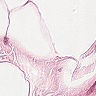

In [7]:
#loading an example image:
print ('Image example:')
plt.imread(f'{train_folder}/0a0a2e923bdedb11f270dcd3f11d0f001df98f00.tif')

## Exploratory Data Analysis (EDA)
From the data overview section, we can see that all the rows in this data have been categorized, so there is no need to remove observations.

Let's check the distirbution of labels in the data: There is a small imbalance in the data, where 60% of the labels are categorized as 0 while only 40% are 1.
It is important to keep it in mind and check if the distribution is the same when we sample the data in the future for training.

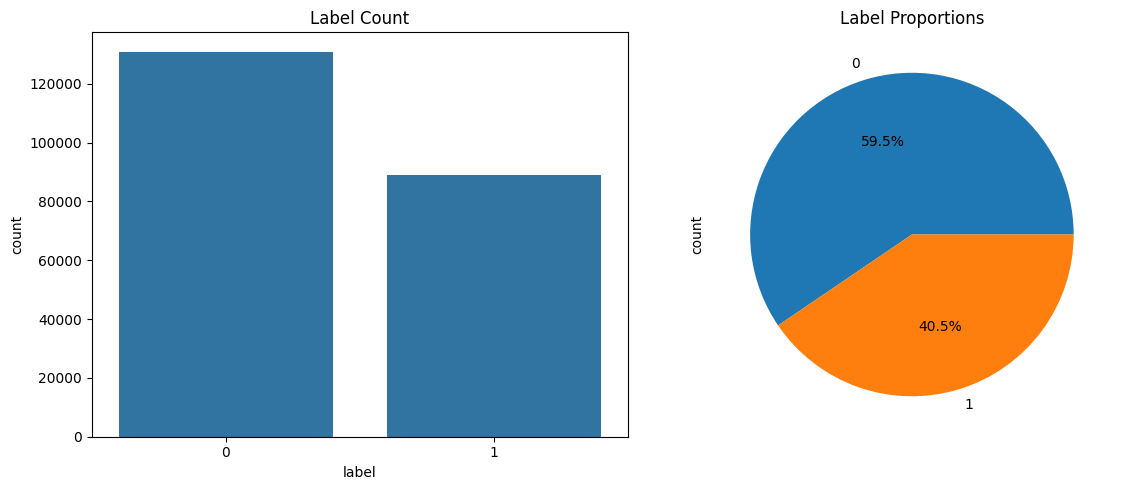

In [8]:
#plotting a pie for label proportions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar plot on the first subplot
sns.barplot(x='label', data=train_labels, y=train_labels['label'].value_counts(), ax=axes[0])
axes[0].set_title('Label Count')

# Pie chart on the second subplot
train_labels['label'].value_counts().plot.pie(autopct='%1.1f%%', ax=axes[1])
axes[1].set_title('Label Proportions')

# Adjust layout and display
plt.tight_layout()
plt.show()



Let's check the images side by side, for both, malignant and benign cancer samples:

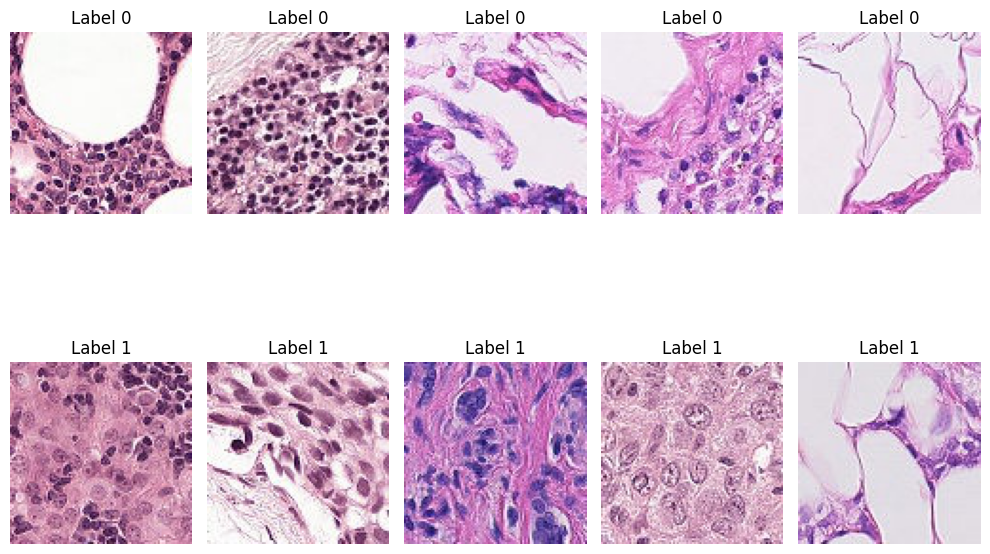

In [8]:
# load image from id - making it easier
def get_image(id):
    return Image.open(train_folder + id + '.tif')

b_images = train_labels[train_labels['label'] == 0].sample(5)
m_images = train_labels[train_labels['label'] == 1].sample(5)

# generate plot with 2 rows 5 columns of images
fig, ax = plt.subplots(2, 5, figsize=(10, 8))

for i in range(len(b_images)):
    ax[0, i].imshow(get_image(b_images.iloc[i]['id']))
    ax[0, i].axis('off')
    ax[0, i].set_title('Label 0')

    ax[1,i].imshow(get_image(m_images.iloc[i]['id']))
    ax[1,i].axis('off')
    ax[1,i].set_title('Label 1')

plt.tight_layout()
plt.show()

## Data Preprocessing
### Data Sampling
Because our dataset is so large, we'll sample 10% of the data for initial analysis and hyperparameter tuning.

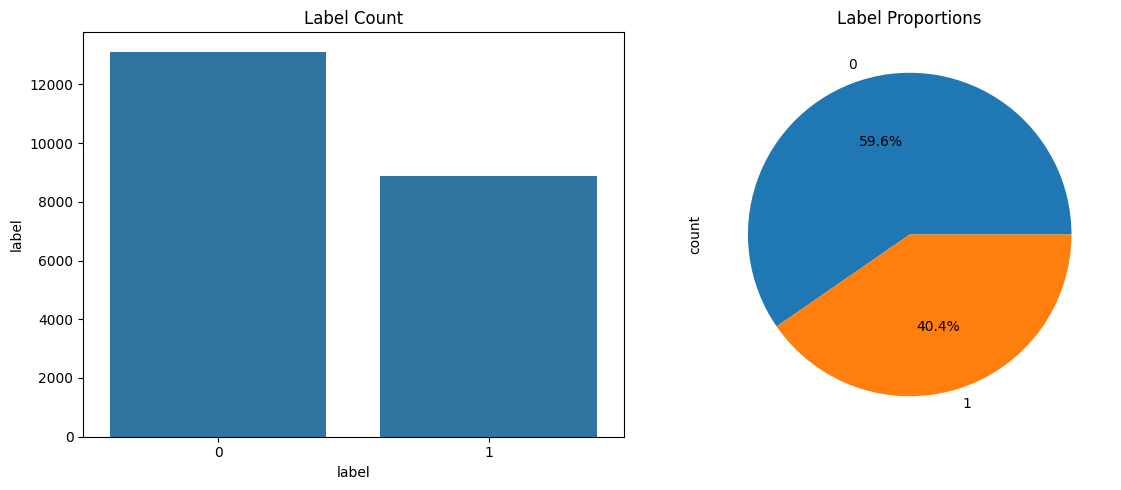

In [7]:
#generating a data sample randomized 10% of the oroginal size
import random
np.random.seed(42)
sample_size = int(0.1 * len(train_labels))
sample_indices = np.random.choice(train_labels.index, size=sample_size, replace=False)

sample_labels = train_labels.loc[sample_indices].copy()

# checking for data distirbution to see if matches original set
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar plot on the first subplot
sns.barplot(x='label', data=sample_labels, y='label', estimator=len, ax=axes[0])
axes[0].set_title('Label Count')

# Pie chart on the second subplot
sample_labels['label'].value_counts().plot.pie(autopct='%1.1f%%', ax=axes[1])
axes[1].set_title('Label Proportions')

# Adjust layout and display
plt.tight_layout()
plt.show()


In [47]:
#checking missing values
print(sample_labels.isnull().sum())

id       0
label    0
dtype: int64


### Image processing
We don't need to drop any observations as they all have all the necessary values to train our model. To do so, we need to get the pixels for every image of the training sample to use in our model and split it in training and validation data. Additionally, we'll crop the image to 32 pixels.

In [9]:
#function that return the pixels for a specific image
def get_ImPixels(id, folder=train_folder):
    return plt.imread(folder + id + ".tif")
#get_ImPixels('0a0a2e923bdedb11f270dcd3f11d0f001df98f00')

def getCentral32(image):
#\returns 32X32x3 central array

    return image[32:64, 32:64]

sample_labels['pixels'] = sample_labels['id'].apply(get_ImPixels)
sample_labels['pixel32'] = sample_labels['pixels'].apply(getCentral32)
sample_labels.head()


,id,label,pixels,pixel32
107796,d293308913e4a40cebb809d986aa9add65a76bfa,0,"[[[41, 32, 37], [41, 32, 37], [41, 32, 37], [4...","[[[47, 38, 43], [47, 38, 43], [47, 38, 43], [4..."
11942,fcd55f03496afb4b11598d9c2231e86da318e723,1,"[[[66, 36, 126], [74, 40, 126], [169, 131, 208...","[[[191, 123, 208], [127, 74, 156], [218, 187, ..."
163858,5c983c8f14afeffdb098b9f3cbb68488a802b957,0,"[[[51, 18, 61], [92, 57, 99], [131, 95, 133], ...","[[[135, 82, 110], [92, 43, 72], [149, 104, 137..."
184810,71bf03e8530348e57ec07d8ce2052f215390c997,0,"[[[242, 244, 243], [241, 243, 242], [240, 242,...","[[[81, 40, 84], [94, 51, 94], [126, 81, 122], ..."
150958,1533406000e26663c5fadac3bcc3e38285a45bb3,1,"[[[104, 60, 139], [170, 125, 208], [178, 132, ...","[[[77, 41, 131], [70, 21, 113], [175, 108, 203..."


## Building the Models
We'll build a base model architecture using Keras sequential, compriised of 4 layers as described below in the code. We'll then train different models using different hyperparameters leveraging the base model architecture to compare results as listed below:


1.   Finding the best learning rate - 10 iterations from 0.0001 to 0.001
2.   Finding the best dropout rate - 8 iterations from 0.1 to 0.8
3.   Finding the best optimizer - options: Adam, SGD, RMSprop
4.   Using Batch Normalization



*It is important to note that if we were solving this image classification problem, the CNN architecture should also be optimizaed, but for this exercise, we'll focus on the optimizers and other model hyperparameters.

In [55]:
#downloading the sample data
sample_labels.to_csv('sample_labels.csv', sep=';', index=False)

In [10]:
#training data
x_train = np.array(sample_labels['pixel32'].tolist())
y_train = np.array(sample_labels['label'])

In [31]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Cropping2D, Input, Rescaling
# from tensorflow.keras.optimizers import Adam

def base_model(dropout_rate = 0.5, batch_normalization  = False):
  #building a keras model
  base_model = Sequential()

  #first layer - adding the data
  base_model.add(Input(shape=(32, 32, 3)))
  base_model.add(Rescaling(1./255))

  #second layer - 64 convolution
  base_model.add(Conv2D(64, (3, 3), activation='relu'))
  base_model.add(MaxPooling2D((2, 2)))
  if batch_normalization:
    base_model.add(BatchNormalization())

  #third layer - 128 convo
  base_model.add(Conv2D(128, (3, 3), activation='relu'))
  base_model.add(MaxPooling2D((2, 2)))
  if batch_normalization:
    base_model.add(BatchNormalization())

  #forth layer - 256 convo
  base_model.add(Conv2D(256, (3, 3), activation='relu'))
  base_model.add(MaxPooling2D((2, 2)))
  if batch_normalization:
    base_model.add(BatchNormalization())

  #flatten & 5th layer
  base_model.add(Flatten())
  base_model.add(Dense(256, activation='relu'))
  base_model.add(Dropout(dropout_rate))
  if batch_normalization:
    base_model.add(BatchNormalization())

  #output layer
  base_model.add(Dense(1, activation='sigmoid'))

  return base_model
  # base_model.summary()

In [16]:
model_A = base_model()
model_A.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 30, 30, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 13, 13, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 633,473 (2.42 MB)

 Trainable params: 633,473 (2.42 MB)

 Non-trainable params: 0 (0.00 B)

### Finding the best learning rate
We'll try iterate over the learning rate to choose the best learning rate for our optimizer.

*   Optimizer: Adam
*   Learning rate: from [0.0001 to 0.01]
*   Loss: binary cross entropy

In [13]:
#compiling a model
lr_array = np.logspace(-4, -2, 10)
model_A = base_model()
best_lr = 0
best_acc = 0
for lr in lr_array:
  print(lr)
  model_A.compile(optimizer=Adam(learning_rate=lr),
                              loss='binary_crossentropy', metrics=['accuracy'])
  model_A.fit(x_train, y_train, epochs=10, validation_split=0.2)
  if model_A.evaluate(x_train, y_train)[1] > best_acc:
    best_acc = model_A.evaluate(x_train, y_train)[1]
    best_lr = lr

0.0001
Epoch 1/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.6556 - loss: 0.6103 - val_accuracy: 0.7507 - val_loss: 0.5176
Epoch 2/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7539 - loss: 0.5167 - val_accuracy: 0.7589 - val_loss: 0.5083
Epoch 3/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7612 - loss: 0.5079 - val_accuracy: 0.7589 - val_loss: 0.5065
Epoch 4/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7618 - loss: 0.5046 - val_accuracy: 0.7616 - val_loss: 0.5014
Epoch 5/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7700 - loss: 0.4939 - val_accuracy: 0.7532 - val_loss: 0.5238
Epoch 6/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7709 - loss: 0.4934 - val_accuracy: 0.7589 - val_loss: 0.5172
Epoch 7/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7748 - loss: 0.4875 - val_accuracy: 0.7741 - val_loss: 0.4889
Epoch 8/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7811 - loss: 0.4689 - val_acc

In [14]:
print(f'Best accuracy: {best_acc}')
print(f'Best learning rate: {round(best_lr, 5)}')

Best accuracy: 0.9369148015975952
Best learning rate: 0.00129


### Trying Models with different dropout rates
*   Optimizer: Adam
*   Learning rate: 0.00129 - using best rate from previous exercises
*   Dropout rate from [0.1 to 0.8] with 0.1 increments
*   Loss: binary cross entropy

In [47]:
# for droput rates from 0.1 t0 0.9
dropout_rates = np.arange(0.1, 0.9, 0.1)
best_dr = 0
best_acc = 0
for dr in dropout_rates:
  print(dr)
  model_B = base_model(dropout_rate = dr)
  model_B.compile(optimizer=Adam(learning_rate=best_lr), loss='binary_crossentropy', metrics=['accuracy'])
  model_B.fit(x_train, y_train, epochs=10, validation_split=0.2)
  if model_B.evaluate(x_train, y_train)[1] > best_acc:
    best_acc = model_B.evaluate(x_train, y_train)[1]
    best_dr = dr

0.1
Epoch 1/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.6292 - loss: 0.6341 - val_accuracy: 0.7396 - val_loss: 0.5360
Epoch 2/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7560 - loss: 0.5198 - val_accuracy: 0.7519 - val_loss: 0.5208
Epoch 3/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7652 - loss: 0.5066 - val_accuracy: 0.7416 - val_loss: 0.5290
Epoch 4/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7683 - loss: 0.4985 - val_accuracy: 0.7680 - val_loss: 0.4950
Epoch 5/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7821 - loss: 0.4787 - val_accuracy: 0.7610 - val_loss: 0.5024
Epoch 6/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7789 - loss: 0.4726 - val_accuracy: 0.7651 - val_loss: 0.4953
Epoch 7/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7883 - loss: 0.4631 - val_accuracy: 0.7455 - val_loss: 0.5202
Epoch 8/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8010 - loss: 0.4399 - val_accuracy

In [48]:
print(f'Best dropout rate: {best_dr}')
print(f'Best accuracy: {best_acc}')

Best dropout rate: 0.5
Best accuracy: 0.8583765029907227
Best learning rate: 0.001291549665014884


Interestingly the best dropout rate is 0.5 (50%).

### Testing different optimizers

* Optimizers: [Adam, sgd, rmsprop]
* Learning rate: 0.00129
* Dropout rate 0.5
* Loss: binary cross entropy

In [20]:
from tensorflow import keras
best_dr=0.5
best_lr= 0.001291549665014884
optimizers = [keras.optimizers.Adam(learning_rate=best_lr),
              keras.optimizers.SGD(learning_rate=best_lr),
              keras.optimizers.RMSprop(learning_rate=best_lr)]
# optimizers = ['adam','sgd','rmsprop']
best_opt = 0
best_acc = 0
model_C = base_model()
for opt in optimizers:
  print(opt)
  model_C.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  model_C.fit(x_train, y_train, epochs=10, validation_split=0.2)
  if model_C.evaluate(x_train, y_train)[1] > best_acc:
    best_acc = model_C.evaluate(x_train, y_train)[1]
    best_opt = opt


Epoch 1/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.6618 - loss: 0.6134 - val_accuracy: 0.7348 - val_loss: 0.5549
Epoch 2/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7434 - loss: 0.5441 - val_accuracy: 0.7555 - val_loss: 0.5128
Epoch 3/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7638 - loss: 0.5082 - val_accuracy: 0.7698 - val_loss: 0.4862
Epoch 4/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7655 - loss: 0.4946 - val_accuracy: 0.7501 - val_loss: 0.5240
Epoch 5/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7824 - loss: 0.4762 - val_accuracy: 0.7719 - val_loss: 0.4919
Epoch 6/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7793 - loss: 0.4758 - val_accuracy: 0.7869 - val_loss: 0.4660
Epoch 7/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8057 - loss: 0.4440 - val_accuracy: 0.7635 - val_loss: 0.4960
Epoch 8/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8046 - loss: 0.4372 - val_accuracy: 0.

In [23]:
print(f'Best optimizer: {best_opt}')
print(f'Best accuracy: {best_acc}')

Best Optimizer: RMSprop
Best accuracy: 0.8902372717857361


RMSprop showed a slighter improvement over Adam.

### Using Batch Normalization
For this last step, we'll train 2 models to compare performance:
1. Base Model, with the best parameters from the steps above, without Batch Normalization
2. Base Model, with the same parameters as Model 1, **with** Batch Normalization

Overview:
* Optimizer: RMSprop
* Learning rate: 0.00129
* Dropout rate 0.5
* Loss: binary cross entropy


### Model 1 - No normalization

In [25]:
model1 = base_model(dropout_rate=best_dr, batch_normalization=False)
model1.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 30, 30, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 13, 13, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 633,473 (2.42 MB)

 Trainable params: 633,473 (2.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8381 - loss: 0.3734 - val_accuracy: 0.7264 - val_loss: 0.6166
Epoch 2/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8601 - loss: 0.3358 - val_accuracy: 0.7580 - val_loss: 0.7564
Epoch 3/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8686 - loss: 0.3171 - val_accuracy: 0.7605 - val_loss: 0.6659
Epoch 4/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8794 - loss: 0.2941 - val_accuracy: 0.7728 - val_loss: 0.6865
Epoch 5/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8873 - loss: 0.2768 - val_accuracy: 0.7585 - val_loss: 0.9877
Epoch 6/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8930 - loss: 0.2609 - val_accuracy: 0.7096 - val_loss: 0.6657
Epoch 7/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8939 - loss: 0.2635 - val_accuracy: 0.7557 - val_loss: 0.8849
Epoch 8/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9044 - loss: 0.2454 - val_accuracy: 0.

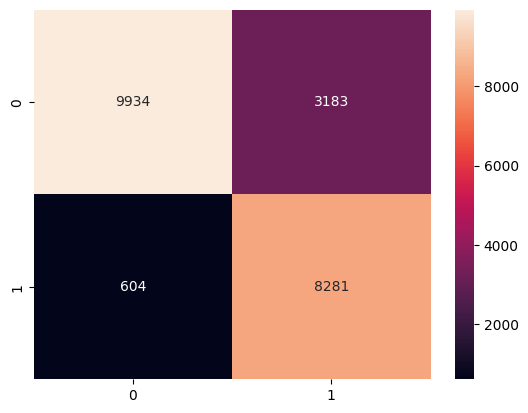

In [45]:
model1.compile(optimizer=keras.optimizers.RMSprop(learning_rate=best_lr), loss='binary_crossentropy', metrics=['accuracy'])
model1.fit(x_train, y_train, epochs=10, validation_split=0.2)

#confusion matrix for the model
print(f'Accuracy: {model1.evaluate(x_train, y_train)[1]}/n')

y_pred = model1.predict(x_train)
y_pred = np.round(y_pred)
cm = confusion_matrix(y_train, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

### Model 2 - With Batch Normalization

In [32]:
model2 = base_model(dropout_rate=best_dr, batch_normalization=True)
model2.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_8 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 30, 30, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 13, 13, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 636,289 (2.43 MB)

 Trainable params: 634,881 (2.42 MB)

 Non-trainable params: 1,408 (5.50 KB)

Epoch 1/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9257 - loss: 0.1966 - val_accuracy: 0.7544 - val_loss: 0.8683
Epoch 2/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9382 - loss: 0.1646 - val_accuracy: 0.7435 - val_loss: 1.0021
Epoch 3/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9443 - loss: 0.1499 - val_accuracy: 0.6301 - val_loss: 2.0845
Epoch 4/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9504 - loss: 0.1362 - val_accuracy: 0.7496 - val_loss: 1.0197
Epoch 5/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9554 - loss: 0.1203 - val_accuracy: 0.7087 - val_loss: 1.5289
Epoch 6/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9581 - loss: 0.1126 - val_accuracy: 0.7312 - val_loss: 0.9336
Epoch 7/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9651 - loss: 0.1012 - val_accuracy: 0.7367 - val_loss: 1.6240
Epoch 8/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9680 - loss: 0.0897 - val_accuracy: 

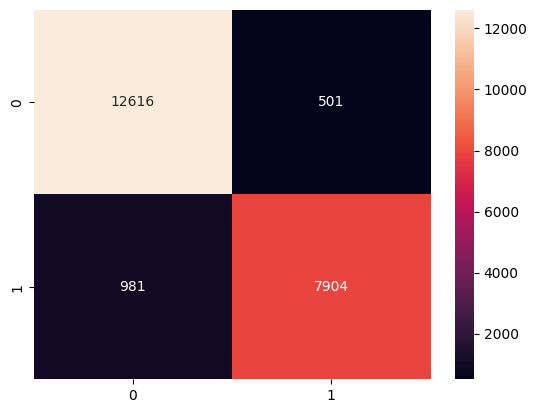

In [49]:
model2.compile(optimizer=keras.optimizers.RMSprop(learning_rate=best_lr), loss='binary_crossentropy', metrics=['accuracy'])
model2.fit(x_train, y_train, epochs=10, validation_split=0.2)

#confusion matrix for the model
print(f'Accuracy: {model2.evaluate(x_train, y_train)[1]}/n')

y_pred = model2.predict(x_train)
y_pred = np.round(y_pred)
cm = confusion_matrix(y_train, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

Batch Normalization shows an improvement over the base model, prooving to be a valuable step for CNNs.

## Discussion & Conclusion
This notebook aimed to build a CNN model for histopathologic cancer detection using a subset of the data provided in the Kaggle competition. The process involved data exploration, preprocessing, model building, and hyperparameter tuning.

### Data Considerations
* Due to the large dataset size, a 10% random sample was used for model development. The class distribution in the sample was similar to the original dataset.
* Image Processing: Images were loaded, and the central 32x32 pixel region was extracted for analysis.

### Model Building and Hyperparameter Tuning
1. Base Model: A sequential CNN model with convolutional, max-pooling, and dense layers was defined as the base architecture.
2. Learning Rate: The Adam optimizer was used initially, and the learning rate was tuned using a range of values. A learning rate of 0.00129 yielded the best accuracy.
3. Dropout Rate: Different dropout rates were tested, and a rate of 0.5 was found to be optimal, preventing overfitting.
4. Optimizer: Different optimizers (Adam, SGD, RMSprop) were compared. RMSprop showed a slight improvement over Adam and was selected for the final models.
5. Batch Normalization: Two final models were trained: Model 1 without batch normalization and Model 2 with batch normalization.

### Conclusion
The CNN models developed in this notebook demonstrate the potential for automated histopathologic cancer detection. Model 2, which incorporated batch normalization, slightly outperformed Model 1, highlighting the benefits of this technique. Further improvements could be explored by using a larger dataset, experimenting with different architectures, and employing data augmentation. Overall, the results suggest that CNNs can be effective tools for assisting medical professionals in cancer diagnosis.

## Predicting the test samples and submitting it to Kaggle

In [56]:
#predicting the test data with model 2
def get_ImPixelsTest(id, folder=test_folder):
    return plt.imread(folder + id + ".tif")
test_labels = pd.read_csv(test_labels_path)
test_labels['pixels'] = test_labels['id'].apply(get_ImPixelsTest)
test_labels['pixel32'] = test_labels['pixels'].apply(getCentral32)

In [58]:
x_test = np.array(test_labels['pixel32'].tolist())
y_test = np.array(test_labels['label'])
y_test_pred= model2.predict(x_test)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


In [59]:
model2.evaluate(x_test, y_test)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6735 - loss: 1.4951


[1.4977293014526367, 0.6733962297439575]